# **Deep Learning**
---

- The task is classify the vegetables.
- Dataset comes from [Vegetable Image Dataset.](https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset)

In [1]:
#importing libraries
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
from dataclasses import dataclass
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

### *Load the dataset*

In [2]:
#path to the directory containing vegetable images
data_path = "VegetableImages"

In [3]:
#image transformation pipeline
transform = transforms.Compose([
    transforms.Resize((30, 30)),  #resize images to a specific size
    transforms.ToTensor(), #convert images to PyTorch tensors
])

In [4]:
#loading datasets using PyTorch ImageFolder
train_dataset = datasets.ImageFolder(root=f'{data_path}/train', transform=transform)
valid_dataset = datasets.ImageFolder(root=f'{data_path}/validation', transform=transform)
test_dataset = datasets.ImageFolder(root=f'{data_path}/test', transform=transform)

In [5]:
#data loaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### *Checking the dataset*

In [6]:
#fetching a batch of features and labels from the training loader
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 3, 30, 30])
Labels batch shape: torch.Size([64])


- Visualize the dataset

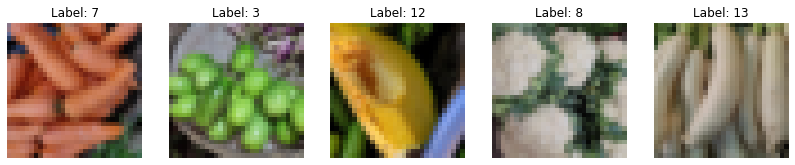

In [7]:
#function to display images with their corresponding labels
def show_images(images, labels):
    fig, axes = plt.subplots(1, 5, figsize=(14,3))

    for i, ax in enumerate(axes):
        ax.imshow(np.transpose(images[i].numpy(), (1,2,0)))
        ax.set_title(f'Label: {labels[i]}')
        ax.axis('off')

    plt.show()

#fetching a batch of images and labels from the training loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

#displaying the first 5 images with labels
show_images(images[:5], labels[:5])

In [8]:
#list of class names corresponding to the dataset labels
class_names = ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomamo']

Size of the original images tensor: torch.Size([64, 3, 30, 30])
Size of the labels tensor: torch.Size([64])


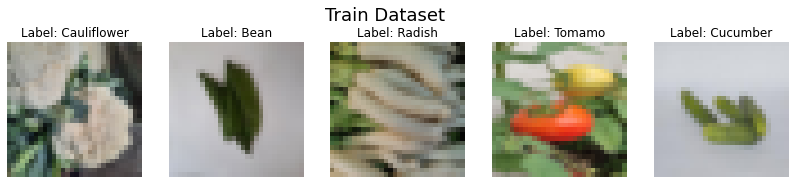

In [9]:
#updated function to display images with class labels
def show_images(images, labels, class_names, title):
    fig, axes = plt.subplots(1, 5, figsize=(14, 3))
    fig.suptitle(title, fontsize=18)

    for i, ax in enumerate(axes):
        img = np.transpose(images[i].numpy(), (1, 2, 0))
        ax.imshow(img)
        ax.set_title(f'Label: {class_names[labels[i].item()]}')
        ax.axis('off')

    plt.show()

#fetching a batch of images and labels from the training loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

#print the sizes of the tensors
print("Size of the original images tensor:", images.size())
print("Size of the labels tensor:", labels.size())

#displaying the first 5 images with labels
show_images(images[:5], labels[:5], class_names, 'Train Dataset')

In [10]:
#displaying the shape of the images in the first 3 samples of the training dataset
for i, (imgs, targets) in enumerate(train_dataset):
    print(imgs.shape)

    if i > 2:
        break

torch.Size([3, 30, 30])
torch.Size([3, 30, 30])
torch.Size([3, 30, 30])
torch.Size([3, 30, 30])


In [11]:
#calculating and printing the total number of samples in the datasets
total_train_data = len(train_loader.dataset)
total_valid_data = len(valid_loader.dataset)
total_test_data = len(test_loader.dataset)

print(f"Total training data: {total_train_data} samples")
print(f"Total validation data: {total_valid_data} samples")
print(f"Total test data: {total_test_data} samples")

Total training data: 15000 samples
Total validation data: 3000 samples
Total test data: 3000 samples


In [12]:
#function to perform inference on the specified data split (train, valid, or test)
@torch.no_grad() #decorator to disable gradient computation during inference
def get_inference(model, type):
    """
    args:
        model: PyTorch model for inference
        type: data split type('train', 'valid', or 'test')
    returns:
        acc: accuracy on the specified data split
        loss: average loss on the specified data split
    """
    #selecting the appropriate data loader based on the specified type
    data_loader = {'train': train_loader,
                   'valid': valid_loader,
                   'test': test_loader}[type]
    correct_pred, num_samples, loss = 0, 0, 0.

    #setting the model to evaluation mode
    model.eval()
    for i, (imgs, targets) in enumerate(data_loader):
        logits = model(imgs)
        probs = F.softmax(logits, dim=1)
        _, preds = torch.max(probs, 1)

        #computing the number of correct predictions and total samples
        correct_pred += (preds == targets).sum()
        num_samples += targets.size(0)

        #computing the loss using cross-entropy
        loss += targets.size(0) * F.cross_entropy(logits, targets)

    #calculating average loss and accuracy
    loss = loss / num_samples
    acc = 100 * correct_pred.float()/num_samples
    return acc, loss

In [13]:
#function to train the model
def train(model, max_epoch, train_loader, optimizer):
    """
    args:
        model: PyTorch model to be trained
        max_epoch: maximum number of training epochs
        train_loader: DataLoader for the training dataset
        optimizer: optimization algorithm  
    returns:
        losses: list of training losses per minibatch
        train_acc_list: list of training accuracies per epoch
        valid_acc_list: list of validation accuracies per epoch
    """
    train_acc_list = [] #list to store training accuracies
    valid_acc_list = [] #list to store validation accuracies
    losses = [] #list to store training losses

    start_time = time.time()
    for epoch in range(max_epoch):
        model.train() #set the model to training mode
        for batch_idx, (imgs, targets) in enumerate(train_loader):
            logits = model(imgs) #forward pass
            loss = F.cross_entropy(logits, targets)
                        
            model.zero_grad(set_to_none=True) #zero out gradients
            loss.backward() #backward pass
            
            optimizer.step() #update weights
            
            losses.append(loss.item()) #append the loss to the list
            if not batch_idx % int(len(train_loader)/2.):
                print(f'Epoch: {epoch+1:03d}/{max_epoch:03d} '
                      f'| Batch: {batch_idx:04d}/{len(train_loader):04d} '
                      f'| Loss: {loss:.4f}')
        
        model.eval() #set the model to evaluation mode
        with torch.no_grad():
            train_acc, _ = get_inference(model, 'train') #calculate training accuracy
            valid_acc, _ = get_inference(model, 'valid') #calculate validation accuracy

            print(f'Epoch: {epoch+1:03d}/{max_epoch:03d} '
                  f'| Train: {train_acc:.2f}% '
                  f'| Valid: {valid_acc:.2f}%')
            print('')

            train_acc_list.append(train_acc.item()) #append training accuracy to the list
            valid_acc_list.append(valid_acc.item()) #append validation accuracy to the list
    
    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')
    return losses, train_acc_list, valid_acc_list

### *Create Model MLP*

In [14]:
#dataclass to hold configuration parameters for the model
@dataclass
class ModelConfig:
    n_in: int = 2700        #number of input features         
    n_hidden: int = 200     #number of hidden units      
    n_out: int = 15         #number of output classes    
    drop_proba: float = 0.5 #dropout probability   
    lamda: float = 0.1      #L2 regularization lambda       
    lr: float = 0.1         #learning rate  
    max_epochs: int = 50    #maximum number of training epochs   

In [15]:
#creating an instance of the ModelConfig dataclass with default values
CONFIG = ModelConfig()
CONFIG

ModelConfig(n_in=2700, n_hidden=200, n_out=15, drop_proba=0.5, lamda=0.1, lr=0.1, max_epochs=50)

In [16]:
#definition of the MLP (Multi-Layer Perceptron) model
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()

        #setting a manual seed for reproducibility
        torch.manual_seed(42)
        #MLP architecture using Sequential
        self.mlp = nn.Sequential(
            nn.Flatten(), #flatten the inpu      
            nn.Linear(config.n_in, 2*config.n_hidden), #fully connected layer
            nn.ReLU(), #ReLU activation function
            nn.Linear(2*config.n_hidden, config.n_out)  #output layer
        )
    def forward(self, X):
        logits = self.mlp(X)
        return logits

In [17]:
#creating an instance of the MLP model using the provided configuration
model_mlp = MLP(CONFIG)

#printing the total number of parameters in the model
print('Total parameters :', sum(p.nelement() for p in model_mlp.parameters()))

Total parameters : 1086415


### *Train Model MLP*

In [18]:
#defining the SGD optimizer for the MLP model
optimizer_mlp = torch.optim.SGD(params = model_mlp.parameters(),
                              lr = CONFIG.lr)

In [19]:
#training the MLP model
losses_mlp, train_acc_mlp, valid_acc_mlp = train(model=model_mlp,
                                                 max_epoch=CONFIG.max_epochs,
                                                 train_loader=train_loader,
                                                 optimizer=optimizer_mlp)

Epoch: 001/050 | Batch: 0000/0235 | Loss: 2.7357
Epoch: 001/050 | Batch: 0117/0235 | Loss: 2.3428
Epoch: 001/050 | Batch: 0234/0235 | Loss: 1.5686
Epoch: 001/050 | Train: 33.35% | Valid: 33.13%

Epoch: 002/050 | Batch: 0000/0235 | Loss: 2.0475
Epoch: 002/050 | Batch: 0117/0235 | Loss: 1.7052
Epoch: 002/050 | Batch: 0234/0235 | Loss: 1.8084
Epoch: 002/050 | Train: 30.55% | Valid: 29.87%

Epoch: 003/050 | Batch: 0000/0235 | Loss: 2.3360
Epoch: 003/050 | Batch: 0117/0235 | Loss: 1.4950
Epoch: 003/050 | Batch: 0234/0235 | Loss: 1.0984
Epoch: 003/050 | Train: 52.61% | Valid: 52.43%

Epoch: 004/050 | Batch: 0000/0235 | Loss: 1.2061
Epoch: 004/050 | Batch: 0117/0235 | Loss: 1.2584
Epoch: 004/050 | Batch: 0234/0235 | Loss: 1.0289
Epoch: 004/050 | Train: 55.87% | Valid: 54.87%

Epoch: 005/050 | Batch: 0000/0235 | Loss: 1.0830
Epoch: 005/050 | Batch: 0117/0235 | Loss: 0.8246
Epoch: 005/050 | Batch: 0234/0235 | Loss: 1.5874
Epoch: 005/050 | Train: 46.79% | Valid: 44.77%

Epoch: 006/050 | Batch: 0

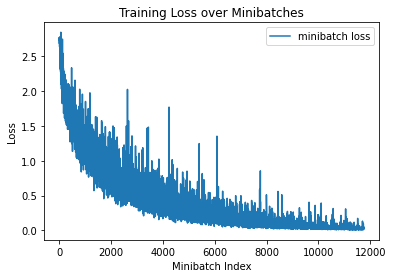

In [20]:
#plotting the training loss over minibatches
plt.plot(np.arange(len(losses_mlp)), losses_mlp, c='tab:blue', label='minibatch loss')
plt.legend()
plt.xlabel('Minibatch Index')
plt.ylabel('Loss')
plt.title('Training Loss over Minibatches')
plt.show()

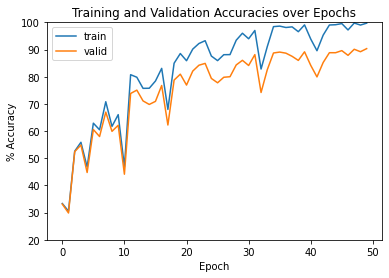

In [21]:
#plotting training and validation accuracies over epochs
plt.plot(np.arange(len(train_acc_mlp)), train_acc_mlp, c='tab:blue', label='train')
plt.plot(np.arange(len(valid_acc_mlp)), valid_acc_mlp, c='tab:orange', label='valid')
plt.ylabel('% Accuracy')
plt.xlabel('Epoch')
plt.ylim(20, 100)
plt.legend()
plt.title('Training and Validation Accuracies over Epochs')
plt.show()

Validate Train and Valid Data

In [22]:
#getting training and validation accuracy and loss for the trained MLP model
train_acc_mlp, train_loss_mlp = get_inference(model_mlp, 'train')
valid_acc_mlp, valid_loss_mlp = get_inference(model_mlp, 'valid')

In [23]:
#creating a summary DataFrame for the MLP model
summary_df = pd.DataFrame(
    np.array([[train_acc_mlp, valid_acc_mlp, train_loss_mlp, valid_loss_mlp]]),
    index = ['MLP'],
    columns = ['Train Acc', 'Valid Acc', 'Train Loss', 'Valid Loss']
)

summary_df

,Train Acc,Valid Acc,Train Loss,Valid Loss
MLP,99.706665,90.333336,0.026292,0.40485


### *Create Model MLP with Dropout*

In [24]:
#definition of the MLP (Multi-Layer Perceptron) model with Dropout
class MLPDropout(nn.Module):
    def __init__(self, config):
        super().__init__()

        #setting a manual seed for reproducibility
        torch.manual_seed(42)
        #MLP architecture using Sequential
        self.mlp = nn.Sequential(
            nn.Flatten(), #flatten the inpu      
            nn.Linear(config.n_in, 2*config.n_hidden), #fully connected layer
            nn.ReLU(), #ReLU activation function
            nn.Dropout(config.drop_proba), #dropout layer
            nn.Linear(2*config.n_hidden, config.n_out)  #output layer
        )
    def forward(self, X):
        logits = self.mlp(X)
        return logits

In [25]:
#creating an instance of the MLP model with Dropout
model_mlpdropout = MLPDropout(CONFIG)

#printing the total number of parameters in the model
print('Total parameters :', sum(p.nelement() for p in model_mlpdropout.parameters()))

Total parameters : 1086415


In [26]:
#defining the SGD optimizer for the MLP model with Dropout
optimizer_mlpdropout = torch.optim.SGD(params = model_mlpdropout.parameters(),
                              lr = CONFIG.lr)

In [27]:
#training the MLP model
losses_mlpdropout, train_acc_mlpdropout, valid_acc_mlpdropout = train(model=model_mlpdropout,
                                                 max_epoch=CONFIG.max_epochs,
                                                 train_loader=train_loader,
                                                 optimizer=optimizer_mlpdropout)

Epoch: 001/050 | Batch: 0000/0235 | Loss: 2.7417
Epoch: 001/050 | Batch: 0117/0235 | Loss: 2.6617
Epoch: 001/050 | Batch: 0234/0235 | Loss: 1.6415
Epoch: 001/050 | Train: 32.09% | Valid: 31.07%

Epoch: 002/050 | Batch: 0000/0235 | Loss: 1.9050
Epoch: 002/050 | Batch: 0117/0235 | Loss: 2.0400
Epoch: 002/050 | Batch: 0234/0235 | Loss: 1.7737
Epoch: 002/050 | Train: 39.79% | Valid: 39.63%

Epoch: 003/050 | Batch: 0000/0235 | Loss: 1.7769
Epoch: 003/050 | Batch: 0117/0235 | Loss: 1.8501
Epoch: 003/050 | Batch: 0234/0235 | Loss: 1.4038
Epoch: 003/050 | Train: 49.42% | Valid: 49.43%

Epoch: 004/050 | Batch: 0000/0235 | Loss: 1.7307
Epoch: 004/050 | Batch: 0117/0235 | Loss: 1.6673
Epoch: 004/050 | Batch: 0234/0235 | Loss: 1.6117
Epoch: 004/050 | Train: 45.18% | Valid: 43.90%

Epoch: 005/050 | Batch: 0000/0235 | Loss: 1.9228
Epoch: 005/050 | Batch: 0117/0235 | Loss: 1.5858
Epoch: 005/050 | Batch: 0234/0235 | Loss: 1.8884
Epoch: 005/050 | Train: 51.54% | Valid: 50.03%

Epoch: 006/050 | Batch: 0

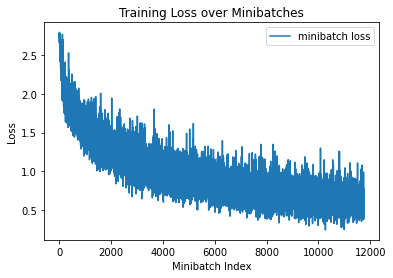

In [28]:
#plotting the training loss over minibatches
plt.plot(np.arange(len(losses_mlpdropout)), losses_mlpdropout, c='tab:blue', label='minibatch loss')
plt.legend()
plt.xlabel('Minibatch Index')
plt.ylabel('Loss')
plt.title('Training Loss over Minibatches')
plt.show()

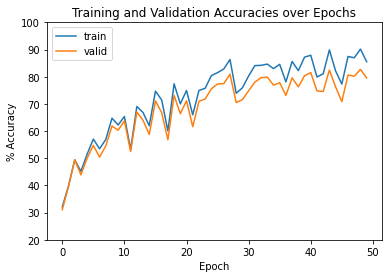

In [29]:
#plotting training and validation accuracies over epochs
plt.plot(np.arange(len(train_acc_mlpdropout)), train_acc_mlpdropout, c='tab:blue', label='train')
plt.plot(np.arange(len(valid_acc_mlpdropout)), valid_acc_mlpdropout, c='tab:orange', label='valid')
plt.ylabel('% Accuracy')
plt.xlabel('Epoch')
plt.ylim(20, 100)
plt.legend()
plt.title('Training and Validation Accuracies over Epochs')
plt.show()

Validate Train and Valid Data

In [30]:
#getting training and validation accuracy and loss for the trained MLP model with Dropout
train_acc_mlpdropout, train_loss_mlpdropout = get_inference(model_mlpdropout, 'train')
valid_acc_mlpdropout, valid_loss_mlpdropout = get_inference(model_mlpdropout, 'valid')

In [31]:
#creating a summary DataFrame for the MLP model with Dropout
summary_df.loc['MLP dropout'] = np.array([train_acc_mlpdropout,
                                         valid_acc_mlpdropout,
                                         train_loss_mlpdropout,
                                         valid_loss_mlpdropout])

summary_df

,Train Acc,Valid Acc,Train Loss,Valid Loss
MLP,99.706665,90.333336,0.026292,0.404850
MLP dropout,85.526665,79.566666,0.488927,0.772836


### *Create Model MLP with Adam Optimization Method*

In [39]:
#creating an instance of the MLP model with Adam using the provided configuration
model_mlpadam = MLP(CONFIG)

#printing the total number of parameters in the model
print('Total parameters :', sum(p.nelement() for p in model_mlpadam.parameters()))

Total parameters : 1086415


In [40]:
#defining the optimizer
optimizer_mlpadam = torch.optim.Adam(params = model_mlpadam.parameters(),
                               lr = 1e-4,
                               betas = (0.9, 0.999))

In [41]:
#training the MLP model with Adam
losses_mlpadam, train_acc_mlpadam, valid_acc_mlpadam = train(model=model_mlpadam,
                                                 max_epoch=CONFIG.max_epochs,
                                                 train_loader=train_loader,
                                                 optimizer=optimizer_mlpadam)

Epoch: 001/050 | Batch: 0000/0235 | Loss: 2.7357
Epoch: 001/050 | Batch: 0117/0235 | Loss: 2.1491
Epoch: 001/050 | Batch: 0234/0235 | Loss: 1.9143
Epoch: 001/050 | Train: 36.85% | Valid: 37.07%

Epoch: 002/050 | Batch: 0000/0235 | Loss: 2.0203
Epoch: 002/050 | Batch: 0117/0235 | Loss: 1.9754
Epoch: 002/050 | Batch: 0234/0235 | Loss: 1.6694
Epoch: 002/050 | Train: 46.64% | Valid: 46.47%

Epoch: 003/050 | Batch: 0000/0235 | Loss: 1.9138
Epoch: 003/050 | Batch: 0117/0235 | Loss: 1.7360
Epoch: 003/050 | Batch: 0234/0235 | Loss: 1.4366
Epoch: 003/050 | Train: 50.19% | Valid: 49.80%

Epoch: 004/050 | Batch: 0000/0235 | Loss: 1.4150
Epoch: 004/050 | Batch: 0117/0235 | Loss: 1.7285
Epoch: 004/050 | Batch: 0234/0235 | Loss: 1.5998
Epoch: 004/050 | Train: 49.48% | Valid: 48.50%

Epoch: 005/050 | Batch: 0000/0235 | Loss: 1.3810
Epoch: 005/050 | Batch: 0117/0235 | Loss: 1.2830
Epoch: 005/050 | Batch: 0234/0235 | Loss: 1.6708
Epoch: 005/050 | Train: 54.68% | Valid: 53.20%

Epoch: 006/050 | Batch: 0

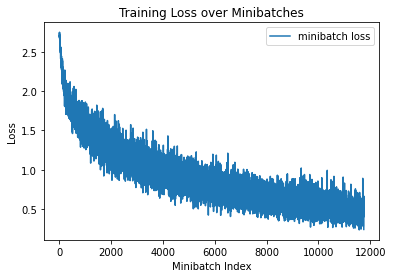

In [42]:
#plotting the training loss over minibatches
plt.plot(np.arange(len(losses_mlpadam)), losses_mlpadam, c='tab:blue', label='minibatch loss')
plt.legend()
plt.xlabel('Minibatch Index')
plt.ylabel('Loss')
plt.title('Training Loss over Minibatches')
plt.show()

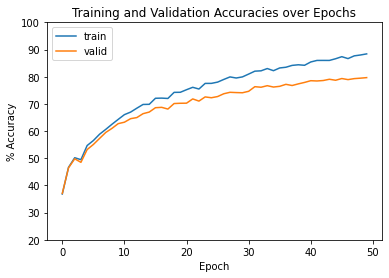

In [43]:
#plotting training and validation accuracies over epochs
plt.plot(np.arange(len(train_acc_mlpadam)), train_acc_mlpadam, c='tab:blue', label='train')
plt.plot(np.arange(len(valid_acc_mlpadam)), valid_acc_mlpadam, c='tab:orange', label='valid')
plt.ylabel('% Accuracy')
plt.xlabel('Epoch')
plt.ylim(20, 100)
plt.legend()
plt.title('Training and Validation Accuracies over Epochs')
plt.show()

Validate Train and Valid Data

In [44]:
#getting training and validation accuracy and loss for the trained MLP model with Adam
train_acc_mlpadam, train_loss_mlpadam = get_inference(model_mlpadam, 'train')
valid_acc_mlpadam, valid_loss_mlpadam = get_inference(model_mlpadam, 'valid')

In [45]:
#creating a summary DataFrame for the MLP model with Adam
summary_df.loc['MLP Adam'] = np.array([train_acc_mlpadam,
                                         valid_acc_mlpadam,
                                         train_loss_mlpadam,
                                         valid_loss_mlpadam])

summary_df

,Train Acc,Valid Acc,Train Loss,Valid Loss
MLP,99.706665,90.333336,0.026292,0.404850
MLP dropout,85.526665,79.566666,0.488927,0.772836
MLP Adam,88.400002,79.666664,0.443951,0.678143


### *Predict the Model Samples*

In [32]:
#setting the device based on GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
#getting class names from the test dataset
class_names_test = test_dataset.class_to_idx.keys()

#display the class names
print(class_names_test)

dict_keys(['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato'])


#### *Predict the MLP Model With Adam*

In [50]:
#setting the MLP model to evaluation mode
model_mlpadam.eval()

#lists to store predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():  
    for inputs, labels in test_loader:
        #moving inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        #forward pass
        outputs = model_mlpadam(inputs)
        _, preds = torch.max(outputs, 1)

        #collecting predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#converting lists to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [51]:
#calculating and printing evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.80
Precision: 0.81
Recall: 0.80
F1 Score: 0.80


In [52]:
#call classification_report with target_names
print(classification_report(all_labels, all_preds, target_names=class_names_test))

              precision    recall  f1-score   support

        Bean       0.70      0.64      0.66       200
Bitter_Gourd       0.77      0.81      0.79       200
Bottle_Gourd       0.82      0.85      0.84       200
     Brinjal       0.67      0.78      0.72       200
    Broccoli       0.82      0.81      0.81       200
     Cabbage       0.69      0.80      0.74       200
    Capsicum       0.88      0.90      0.89       200
      Carrot       0.94      0.98      0.96       200
 Cauliflower       0.86      0.59      0.70       200
    Cucumber       0.85      0.74      0.79       200
      Papaya       0.93      0.83      0.88       200
      Potato       0.92      0.85      0.89       200
     Pumpkin       0.73      0.80      0.76       200
      Radish       0.79      0.94      0.85       200
      Tomato       0.72      0.70      0.71       200

    accuracy                           0.80      3000
   macro avg       0.81      0.80      0.80      3000
weighted avg       0.81   

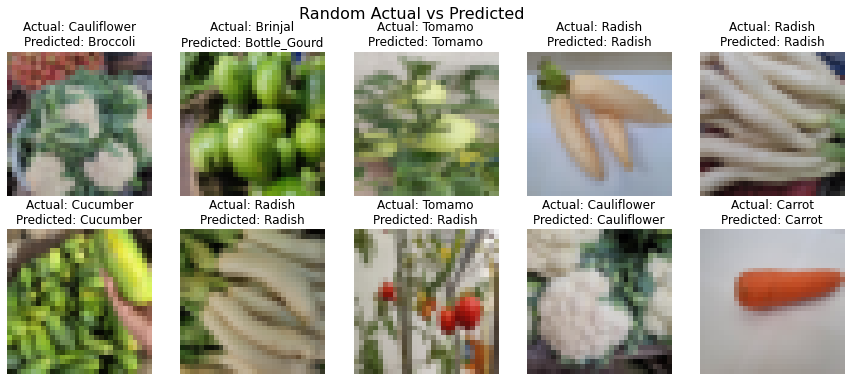

In [53]:
#function to plot random predictions
def plot_random_predictions(model, data_loader, class_names, num_samples=10):
    """
    args:
        model: PyTorch model for predictions
        data_loader: DataLoader for the dataset
        class_names: list of class names
        num_samples: number of random samples to display
    """
    all_images, all_labels = [], []
    #collecting all images and labels from the data loader    
    for images, labels in data_loader:
        all_images.append(images)
        all_labels.append(labels)
    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    #setting the model to evaluation mode
    model.eval()
    with torch.no_grad():
        inputs, labels = all_images.to(device), all_labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        probs = torch.nn.functional.softmax(outputs, dim=1)[range(outputs.shape[0]), preds]

    #selecting random indices for display
    random_indices = np.random.choice(range(all_images.shape[0]), num_samples, replace=False)

    #plotting random predictions
    fig, axes = plt.subplots(2, num_samples // 2, figsize=(15, 6))
    fig.suptitle('Random Actual vs Predicted', fontsize=16)

    for i, random_index in enumerate(random_indices):
        ax = axes[i // (num_samples // 2), i % (num_samples // 2)]
        ax.imshow(np.transpose(all_images[random_index].numpy(), (1, 2, 0)))
        ax.set_title(f'Actual: {class_names[all_labels[random_index].item()]}\nPredicted: {class_names[preds[random_index].item()]}')
        ax.axis('off')

    plt.show()

#plotting random predictions for the MLP model
plot_random_predictions(model_mlpadam, test_loader, class_names, num_samples=10)
